## E6. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

###### 라이브러리 준비

In [12]:
#라이브러리 설치
! conda list | grep xgboost
! conda list | grep lightgbm
! conda list | grep missingno
! pip list | grep scikit-learn
#클라우드에는 이미 라이브러리 설치 되어있어서, 디렉토리만 생성해줌
! mkdir -p ~/aiffel/kaggle_kakr_housing

xgboost                   1.3.3                    pypi_0    pypi
lightgbm                  3.1.1                    pypi_0    pypi
missingno                 0.4.2                    pypi_0    pypi
scikit-learn                  0.23.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 1. 파일 가져오기, Baseline 세팅
##### Data Explorer  
데이터 파일  
이용하는 데이터 파일에 대한 형태 살펴봐야함  
1) train.csv - 모델 학습용 파일 : 데이터 학습  
2) test.csv - 테스트용 파일 : 데이터 price 예측  
3) sample_submission.csv - 제출용 파일 : 해당 형식에 맞는 형태로 제출  

##### 1) 데이터 가져오기

In [13]:
! mkdir -p ~/aiffel/kaggle_kakr_housing/data
! ln -s ~/data/data/*.csv ~/aiffel/kaggle_kakr_housing/data
#fail 메세지 나긴 하는데 일단 아래거 진행하면 됨 ..ㅎ
! ls ~/aiffel/kaggle_kakr_housing/data  # 디렉토리 내 파일 확인

ln: failed to create symbolic link '/aiffel/aiffel/kaggle_kakr_housing/data/sample_submission.csv': File exists
ln: failed to create symbolic link '/aiffel/aiffel/kaggle_kakr_housing/data/test.csv': File exists
ln: failed to create symbolic link '/aiffel/aiffel/kaggle_kakr_housing/data/train.csv': File exists
sample_submission.csv  submission.csv  test.csv  train.csv


##### 2) 베이스라인에 필요한 라이브러리 세팅

In [ ]:
#클라우드에는 이미 설치 되어있음 
! conda install -c conda-forge xgboost=1.3.3
! conda install -c conda-forge lightgbm=3.1.1 
! conda install -c conda-forge missingno=0.4.2

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('얍💢')

얍💢


#### 3) 데이터 경로 지정하기
캐글의 Baseline 커널이 아니라,  
우리의 클라우드 커널 사용할 것임.

그래서 베이스라인의 데이터 경로를 지정해줌

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


## 2. 모델 데이터 살펴보기

##### 1) 데이터 불러오기

In [3]:
data = pd.read_csv(train_data_path) #트레인파일
sub = pd.read_csv(sub_data_path) #테스트 파일

#dim : dimension 차원
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))
#테스트=submission 에는 컬럼이 하나적음 
#price =집 가격은 맞추어야하는 컬럼이기 때문 

train data dim : (15035, 21)
sub data dim : (6468, 20)


##### 2) 학습 데이터에서 라벨 제거하기

price 컬럼은 로 y라는 변수에 저장하고 지움  
price는 타겟데이터 이기 때문임 

train 데이터에서 price 컬럼을 삭제한 data와  
열벡터인 타겟 데이터 y로 학습을 시키고,  
이후 test 데이터를 통해서 얼마나 좋은 성능으로 y값을 예측하는가가 중요함

In [4]:
y = data['price']
del data['price']

print(data.columns)

#위에서는 3번째에 price 변수가 존재했는데  
#현재는 없어진 것 확인 가능 

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


##### 3) data(학습 데이터), sub(테스트 데이터) 합치기
데이터 전처리, EDA 탐색 위해 데이터 잠시 합치기  
재분리를 위해서, 학습 데이터(data)의 개수 변수에 저장해두기

In [5]:
train_len = len(data)
#pd.concat : 두 데이터 합치는 함수
data = pd.concat((data, sub), axis=0)

print(len(data))
#21503 까지 학습 데이터가 존재

21503


In [6]:
data.head()

#훈련과 테스트 합친 data 확인

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


##### 4)  data의 열= 특성= feature= 컬럼 21개  살펴보기
각 컬럼이 나타내는 의미

1) ID : 집을 구분하는 번호  
2) date : 집을 구매한 날짜  
3) price : 타겟 변수인 집의 가격  
4) bedrooms : 침실의 수  
5) bathrooms : 침실당 화장실 개수  
6) sqft_living : 주거 공간의 평방 피트  
7) sqft_lot : 부지의 평방 피트  
8) floors : 집의 층 수  
9) waterfront : 집의 전방에 강이 흐르는지 유무  
10) view : 집이 얼마나 좋아 보이는지의 정도  
11) condition : 집의 전반적인 상태  
12) grade : King County grading 시스템 기준으로 매긴 집의 등급  
13) sqft_above : 지하실을 제외한 평방 피트  
14) sqft_basement : 지하실의 평방 피트  
15) yr_built : 집을 지은 년도  
16) yr_renovated : 집을 재건축한 년도  
17) zipcode : 우편번호  
18) lat : 위도  
19) long : 경도  
20) sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  
21) sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  

In [7]:
data.head()

#훈련과 테스트 합친 data

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 3. 데이터 전처리

##### 1) 결측치 탐색

  ① 결측치 시각화로 확인 

<AxesSubplot:>

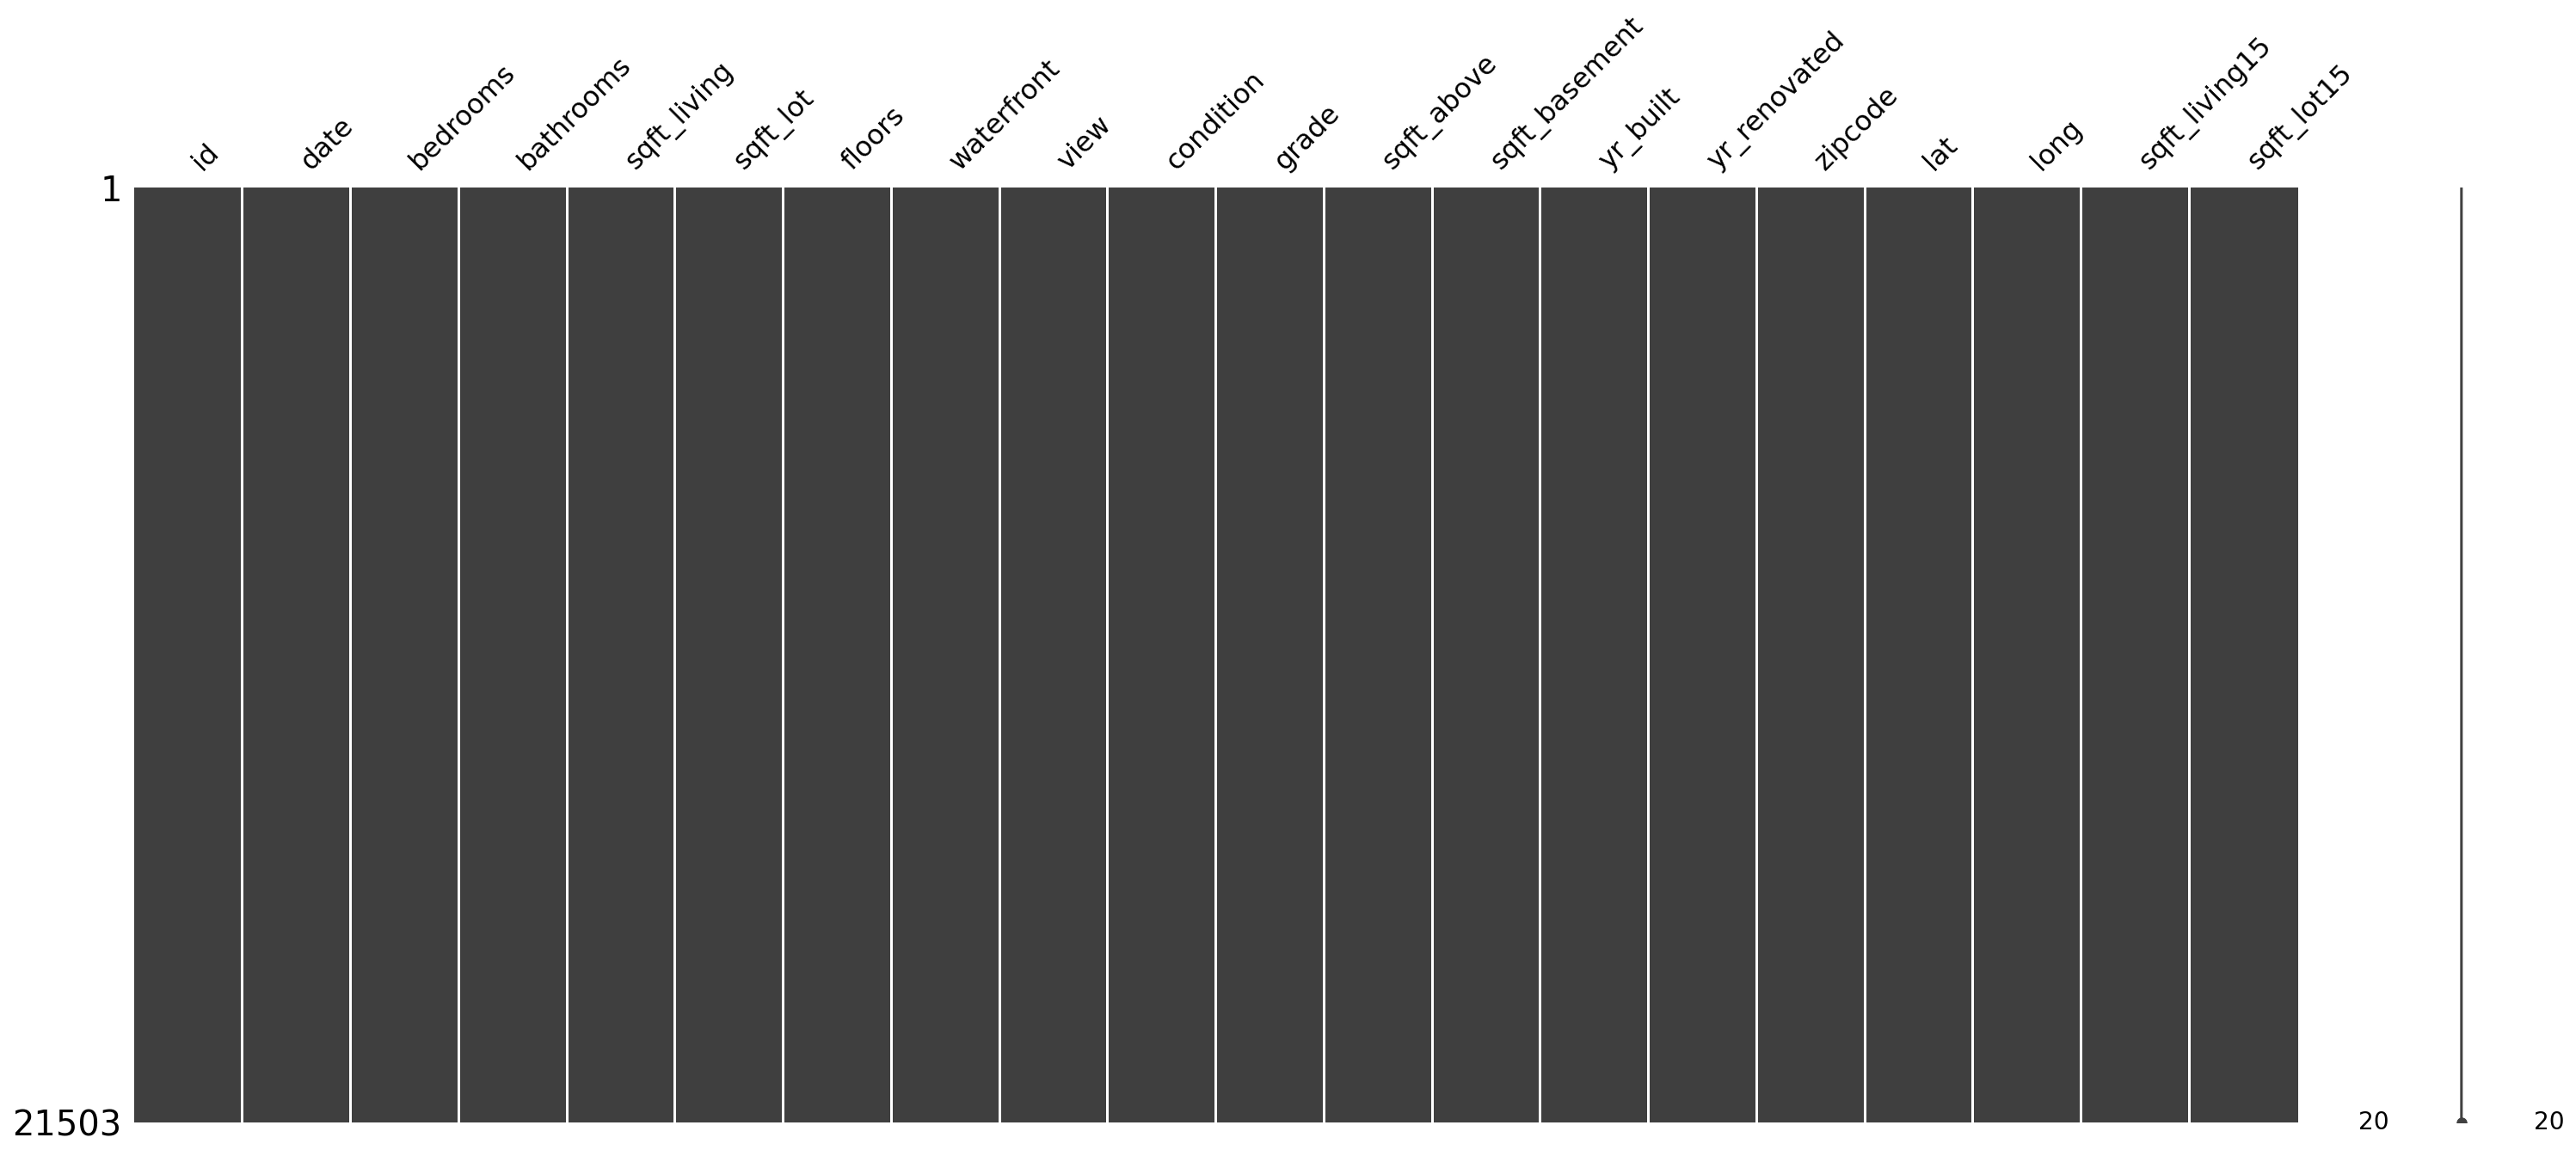

In [8]:
#결측치 시각화로 확인 
msno.matrix(data)

#data라는 DF(데이터 프레임)을 매트릭스 모양으로 시각화
#여기서 data는 위에서 train이랑 sub랑 합친 데이터 프레임
#결측치가 있으면 해당 부분에 하얗게 나옴 
#지금은 다 까맣게 나오는것 확인 가능 = 결측치 없음 


 ② 결측치 수치화로 확인

확인 순서  
1. id컬럼이 결측치인지 확인합니다.  
2. 결측치인 데이터만 뽑아냅니다.  
3. 결측치인 데이터의 개수를 셉니다.  

In [9]:
#pd.isnull() : 해당(c) 컬럼 결측치 인지 확인
#data.loc[] : c 컬럼에서 결측치인 데이터만 인덱싱해서 가져옴
#len : 개수 카운팅
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


##### 2)  id변수 정리
id는 0,1,2,3...이런거니까, 집값 예측에 대한 변수가 아님 

In [10]:
#id변수 정리
#sub_id = sub의 id 컬럼 저장 : 예측 결과 제출시를 위해
sub_id = data['id'][train_len:]

#그리고 모든 데이터에서 필요 없는 id 컬럼 제거 
del data['id']

print(data.columns)
#id 컬럼 삭제 확인 가능

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


##### 3) date 변수 정리
date 값들 20141013T000000 이런식으로 시간까지 포함한 값   
그러나 년도, 월만 고려할 것임

In [11]:
#date변수 정리
#apply 함수: 필요한 부분만 도출

#문자열의 인덱스 5위치까지만 도출
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


##### 4) 각 변수들의 분포 확인

너무 치우친 분포를 가지는 컬럼 다듬어 주기  
시각화 코드 통해 (id 컬럼 제외한) 19개의 컬럼에 대한 그래프 그리기

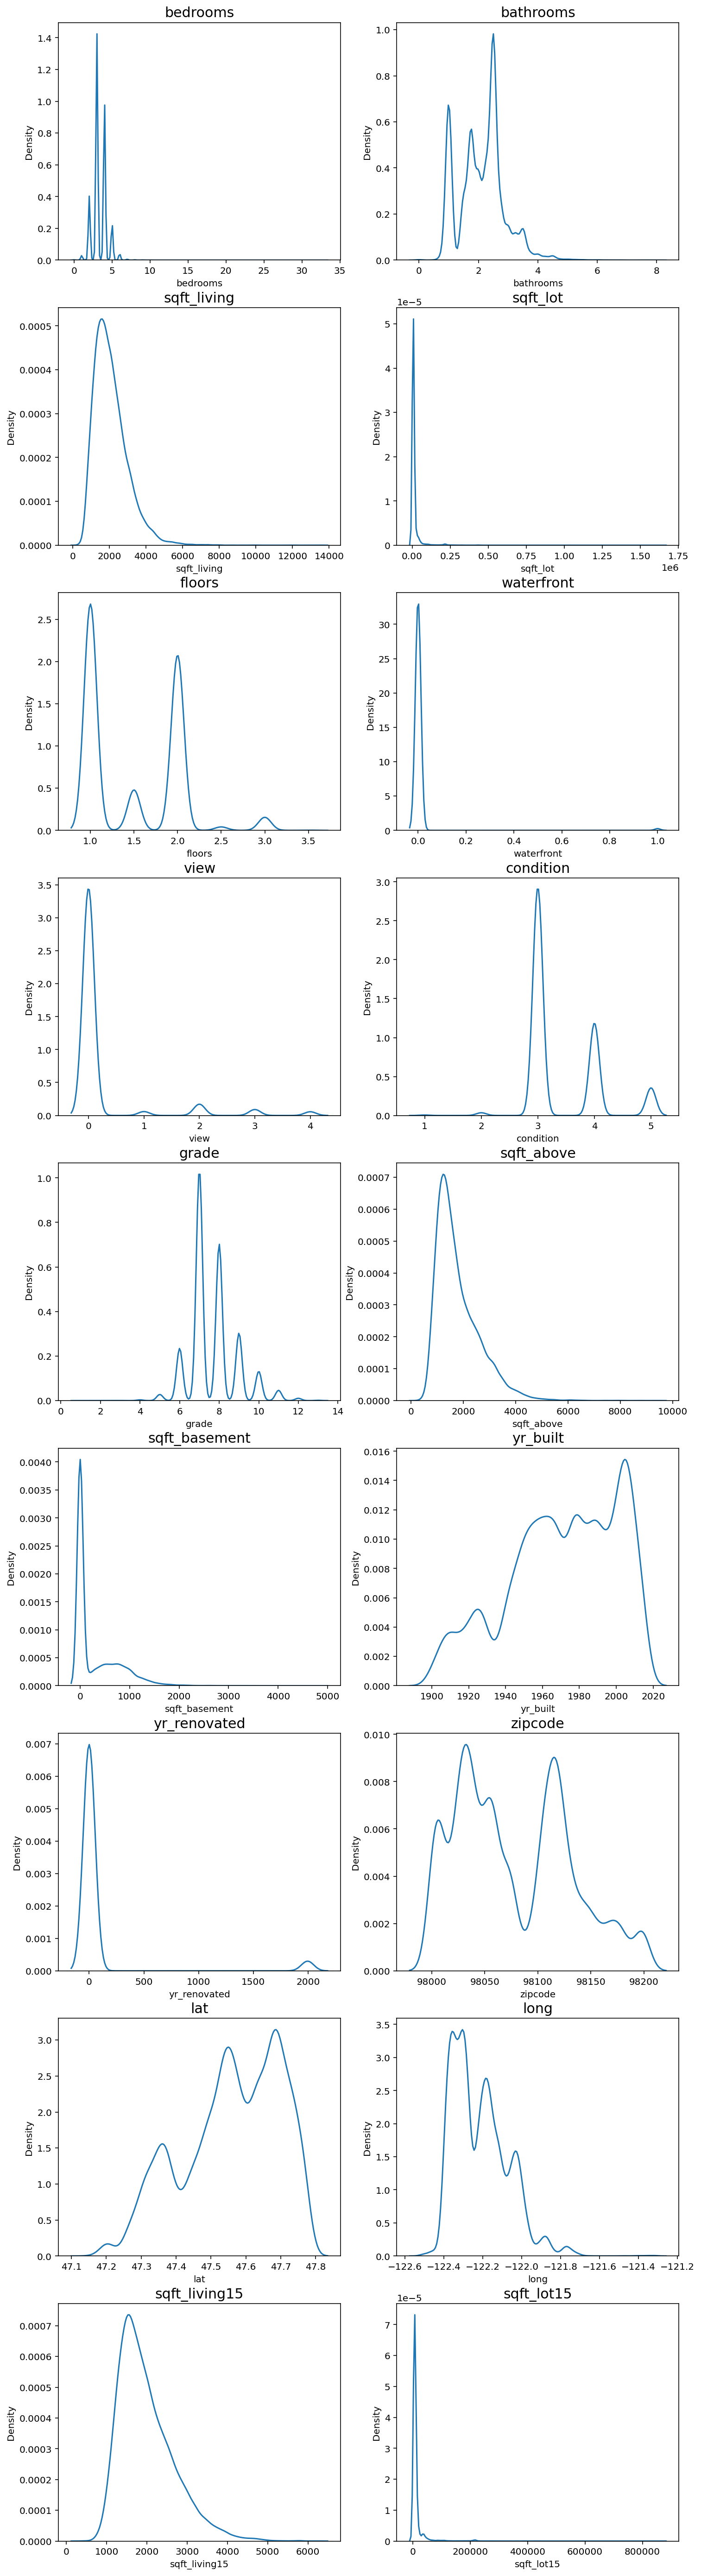

In [12]:
#9개 그래프를, 2열로 그릴거야 
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

#count로 나중에 컬럼 인덱스 할 예정
# id , date 변수(count==0인 경우)는 제외하고 분포 확인
count = 1
columns = data.columns

#이중 for문으로 9개 그래프 2열 -> 10행 2열로 그래프 그림
for row in range(9):
    for col in range(2):
        #sns.kdeplot : 그래프 종류 (kdeplot:이산(discrete) 데이터도 부드러운 곡선으로 표현하는 시각함수)
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break
            
#bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, 
#sqft_living15, sqft_lot15 변수들 한쪽 치우침 경향 보임

#### 5) 각 변수들 분포 다듬기
위에서 한쪽으로 치우치는 경향을 보이는 데이터에 관해  
로그 변환(log-scaling)으로 데이터 분포를 정규 분포에 가깝게 만들어줌  
이후 원래 scale로 되돌리기 위해서는 exp1() 이용

--- 여기서 잠깐 : 로그 함수는 어떻게 데이터 분포를 정규화 해주지?

##### ①일반 로그 함수

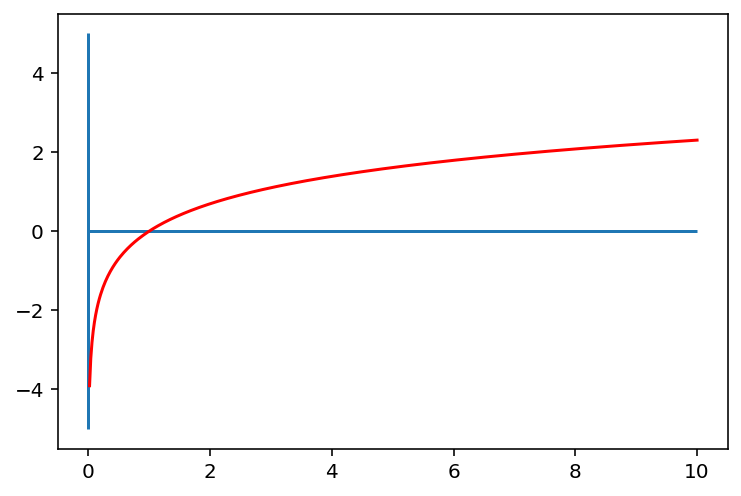

In [13]:
#일반적 로그 함수 
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

위 그래프로 알 수 있는 로그함수의 특징 
1. 0 < x < 10<x<1 범위에서는 기울기가 매우 가파릅니다.  
   즉, x의 구간은 (0, 1)(0,1)로 매우 짧은 반면, y의 구간은 (-\infty, 0)(−∞,0)으로 매우 큼  
2. 따라서 0에 가깝게 모여있는 값들이 x로 입력되면,  
   그 함수값인 y 값들은 매우 큰 범위로 벌어지게 됨  
3. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을  
   넓은 범위로 펼칠 수 있는 특징을 가짐  
4. 반면, x값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아짐  
이는 곧 큰 x값들에 대해서는 y값이 크게 차이나지 않게 된다는 뜻이고,  
따라서 넓은 범위를 가지는 x를 비교적 작은 y값의 구간 내에 모이게 하는 특징을 가짐

-> 왼쪽으로 치우친 값들은 보다 넓은 범위로 고르게 퍼지고  
오른쪽으로 얇고 넓게 퍼진 값들은 보다 작은 범위로 모이게 되므로  
전체 분포는 정규분포의 형상을 띄는 방향으로 변환됨

##### ② 각 변수 분포 정규화하기

In [14]:
#skew_columns =치우친 컬럼들 다 담은 리스트
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

#컬럼 하나씩 가져와서 데이터 분포 log로 정규화 해줌
for c in skew_columns:
    data[c] = np.log1p(data[c].values)
    
    
#아까보다 쏠림 현상이 개선된 것 확인 가능

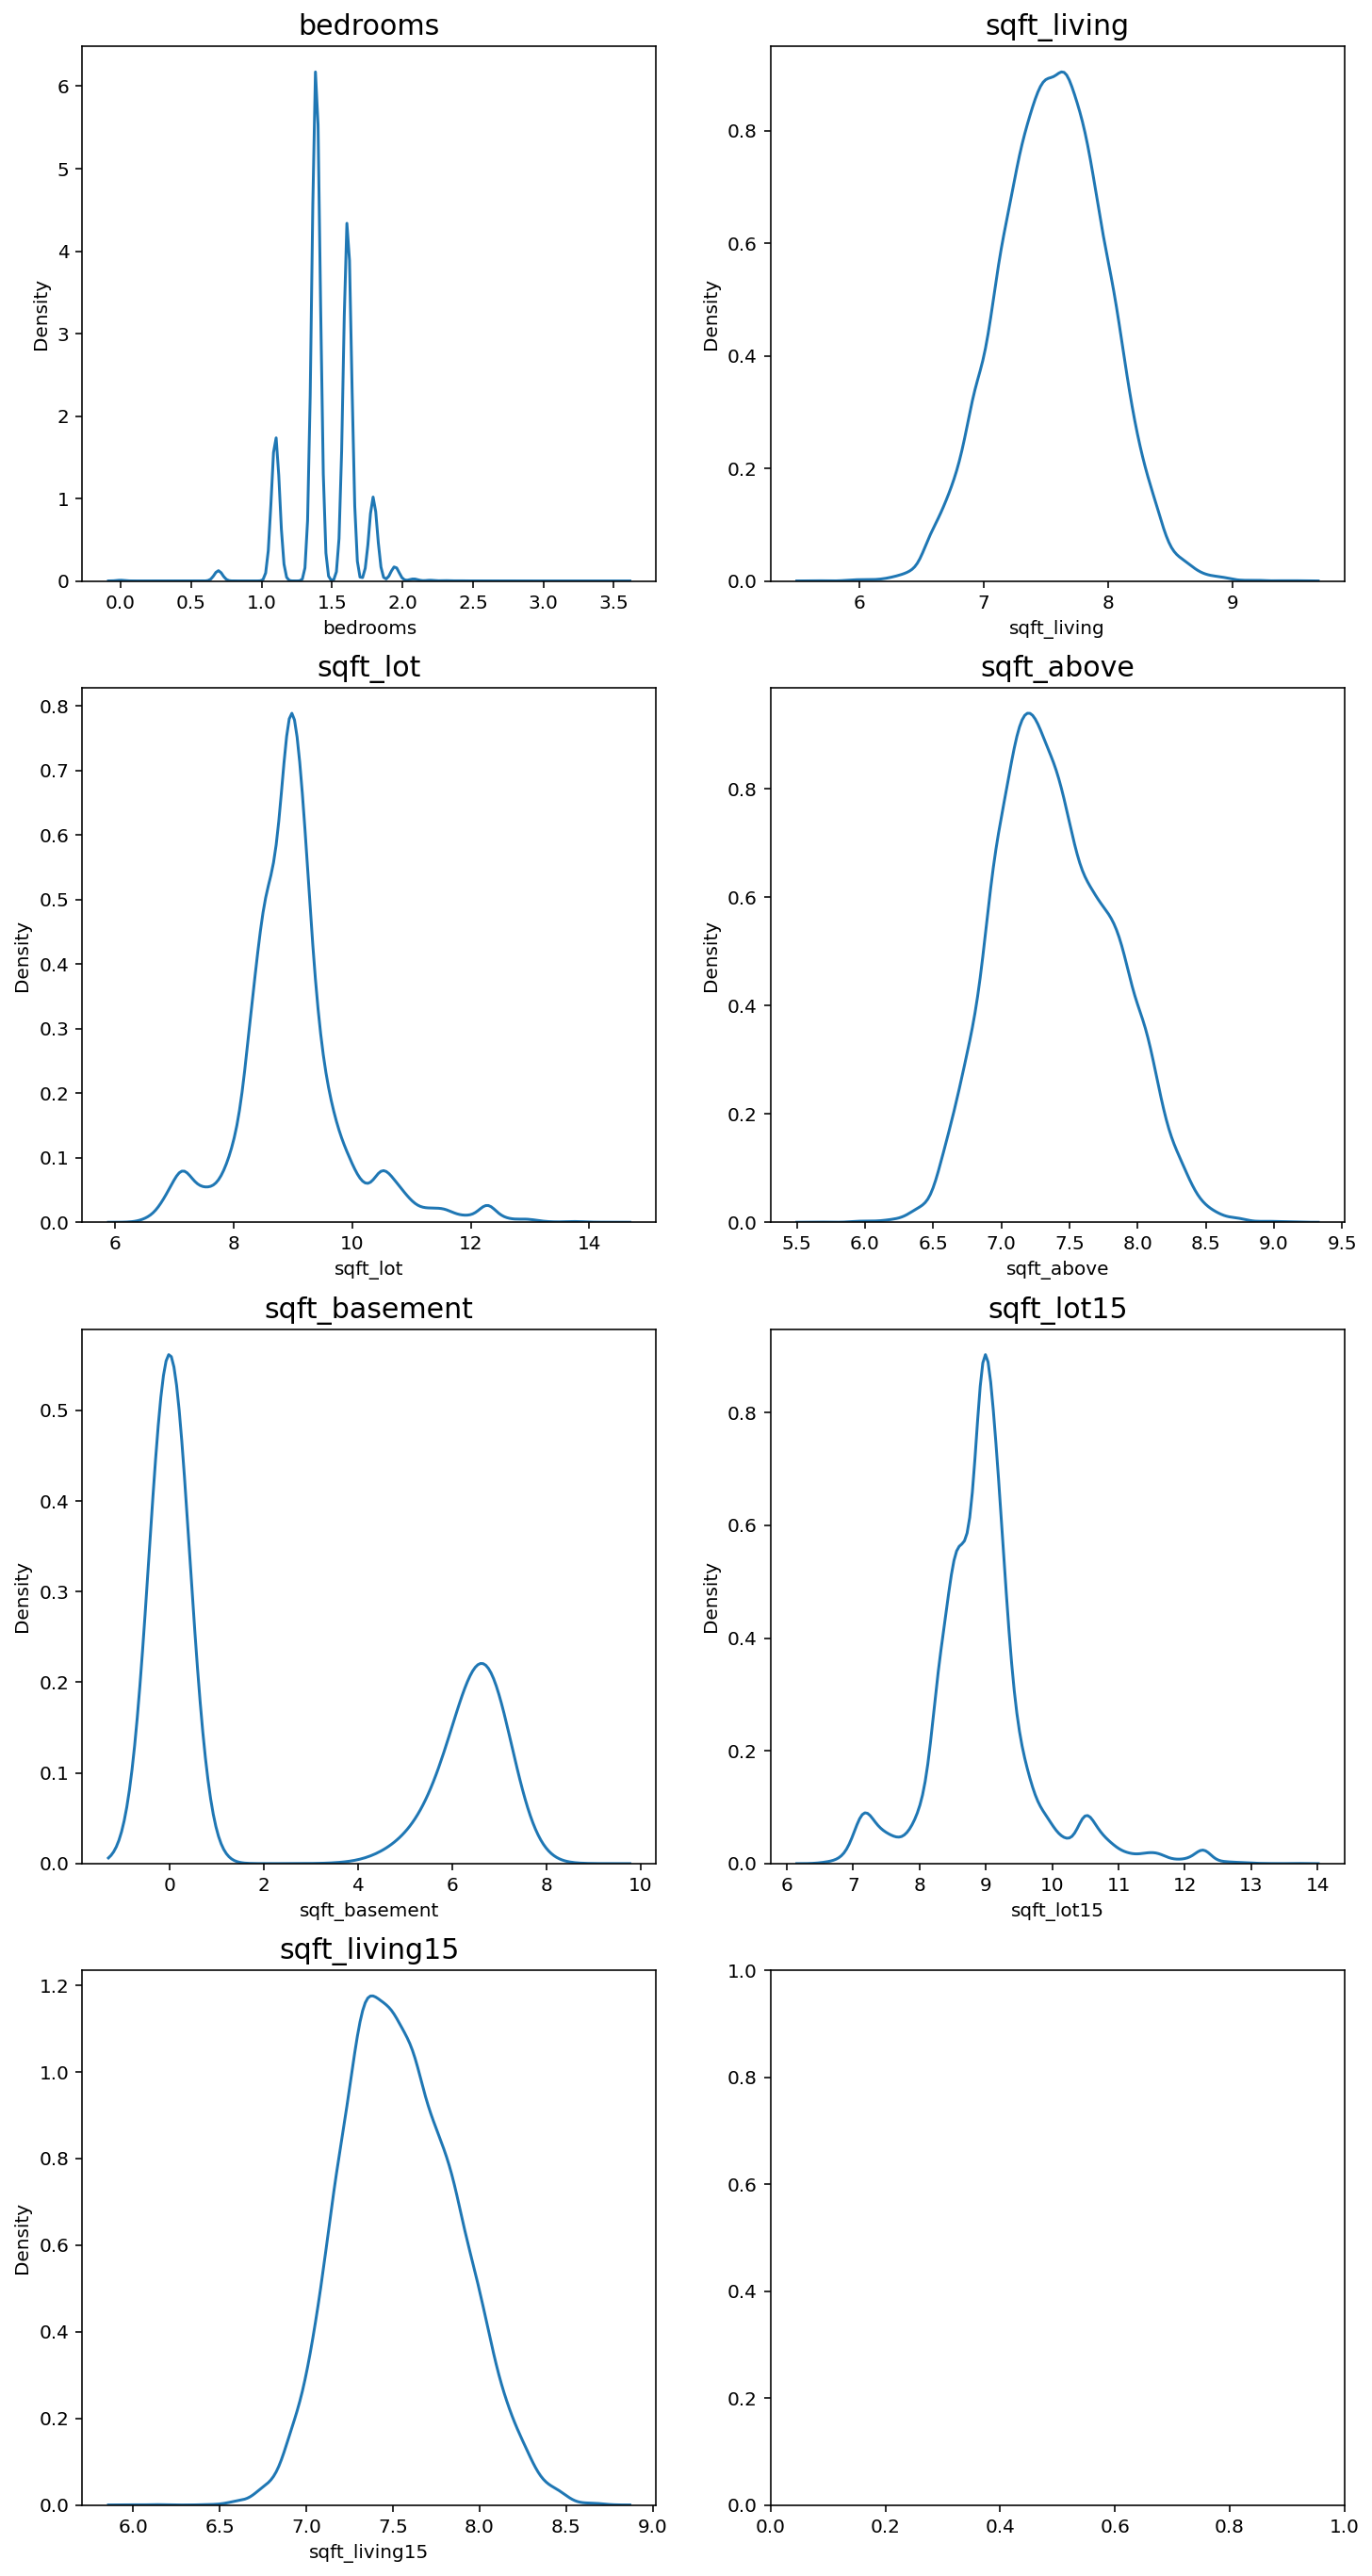

In [15]:
#정규화해서 다시 데이터 분포 시각화해서  확인해보기
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

##### ③ price =y =타겟데이터 의 분포 정규화하기

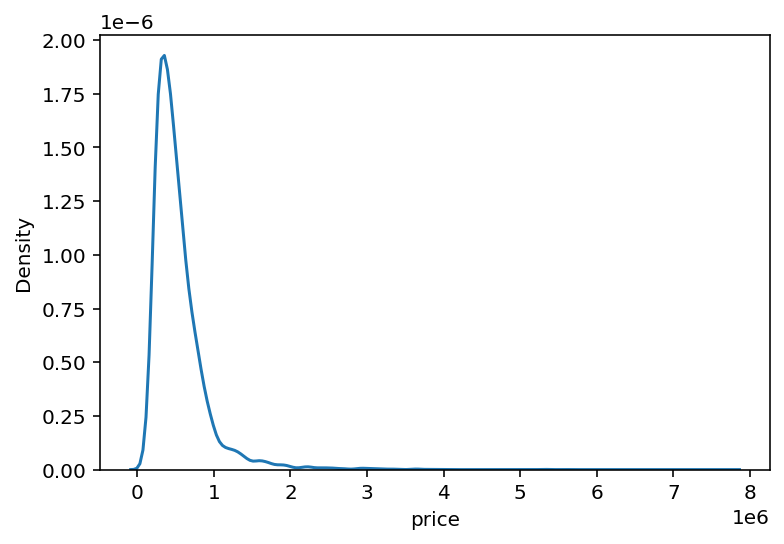

In [16]:
#집 가격= 우리가 예측해야하는 타겟값의 분포
sns.kdeplot(y)
plt.show()

#가격 데이터의 분포도 쏠림 현상 보임

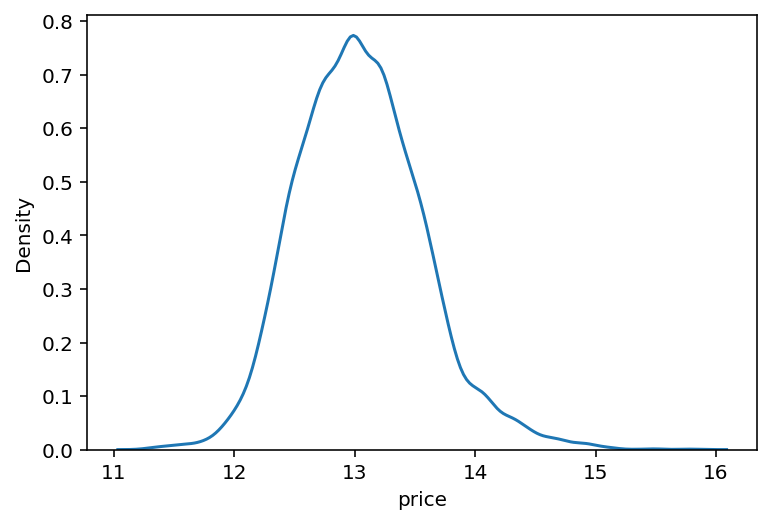

In [17]:
#타겟데이터 로그함수로 데이터 분포 정규화하기
y_log_transformation = np.log1p(y)

#정규화한 타겟 데이터 분포 시각화
sns.kdeplot(y_log_transformation)
plt.show()

#정규분포의 모양으로 가까워짐

##### 6) 다듬기도 하고, 살펴보기도 했으니 이제 다시 train, sub 분리

In [18]:
#x= :train_len까지는 학습 데이터
#sub : train_len 다음 부터, 실제로 추론을 해야 하는 테스트 데이터
#[]안에 뒤 ': '는 열= 컬럼 범위 모두가져오겠다는 의미
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)
#price, id 제외

(15035, 19)
(6468, 19)


## 4. 모델 설계
##### 앙상블이란?  
앙상블(Ensemble) 학습은 여러 개의 학습 알고리즘을 사용하고,  
그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법  
하나의 강한 머신러닝 알고리즘보다  
여러 개의 약한 머신러닝 알고리즘이 낫다  
가장 많이 알려진 앙상블 학습 유형 : Voting, Bagging, Boosting, Stacking

##### 보팅(Voting) = 에버리징(Averaging)  
가장 쉬운 앙상블 기법  
서로 다른 알고리즘을 가진 분류기를 결합하는 방식  
Voting은 분류, Averaging은 회귀 에서 사용  
(categorical인 경우에는 voting, numerical인 경우에는 averaging이기도)

Voting은 여러 모델이 분류해 낸 결과들로부터 다수결 투표를 통해  
최종 결과를 선택하는 방법으로, 분류 문제에서 사용  
Averaging은 각 모델이 계산해 낸 실숫값들을 평균 혹은 가중평균하여  
사용하는 방법으로, 회귀 문제에서 사용

##### 배깅(Bagging)
평균을 통해 분산(variance)값을 줄여 모델을 더 일반화

의사결정 나무  
: A분류 기준이나 체크리스트(?) 같은 걸 만듦  
그래서 새로운 데이터가 들어오면 그 체크리스트를 바탕으로 하나씩 질문하고  
거기서 나온 답에 대한 다음 나무 줄기를 따라가다가  
결국에는 ‘이건 어떤 레이블이겠구나’라고 분류를 해줄 수 있게 되는것  

배깅은 학습 데이터 세트에 총 1000개의 행 중에서  
임의로 100개씩 행을 선택해서 이런 의사결정 트리를 만드는 것
(단, 중복 허용  
1000개의 행이 있는 가방(bag)에서 임의로 100개 뽑아 첫 번째 트리를 만들고  
그 100개의 행은 가방에 도로 집어 넣는다.  
그리고 다시 1000개의 행에서 또 임의로 100개를 뽑아 두 번째 트리를 만든 후  
다시 가방에 집어 넣고 ...)  

##### 부스팅  
여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하며  
잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식

##### 스태킹  
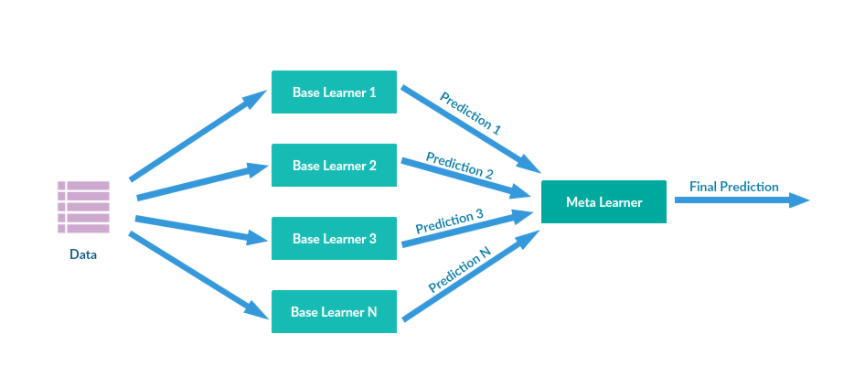

머신러닝 알고리즘으로 훈련 데이터셋을 통해 새로운 데이터셋을 만들고,  
이를 데이터셋으로 사용하여 다시 머신러닝 알고리즘을 돌리는 것
= 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로  
최종 메타 모델이 학습할 별도의 학습 데이터 세트와  
예측할 테스트 데이터 세트를 재 생성하는 기법  

##### 블렌딩
스태킹과 매우 유사한 방법 (스태킹+ 정보 누설 위험 감소)  
Stacking에서는 cross-fold-validation을 사용하고,  
Blending은 holdout validation을 사용  



##### 1) Average Blending 해보자  
1) 부스팅 계열 모델들을 통해 가중치를 고려하여 output 값 생성   
2) 각 모델이 계산해 낸 output들을 평균 혹은 가중평균 하여 베이스 러너 모델 생성 : 에버리지  
3) 해당 모델로 메타 러너를 만듦 : 블렌딩

In [19]:
#gboost, xgboost, lightgbm = 부스팅 계열 모델 3가지
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


##### 2) Cross Validation 
교차검증 통한 간단한 모델 성능 평가 함수 생성

https://brunch.co.kr/@elicecoding/37

In [20]:
def get_cv_score(models):
    #  n_splits : 데이터 분할 수
    # get_n_splits(x.values) : x.values의 수만큼 데이터를 나눔
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        #cross_val_score(): 회귀모델을 전달할 경우 R^2 점수 반환
        #R^2이 1에 가까울 수록 학습 잘 된 것
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

#결정계수 = R^2에 대한 글 
#https://newsight.tistory.com/259

얍💢


각 모델에 대한 위 함수의 결과= 성능 결과

In [21]:
get_cv_score(models)

#3개 모두 훈련데이터에서 적정 수준 이상의 성능을 보여주고 있음

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


##### 3) Submission 테스트 제출 결과 만들기

제출 결과 값= 예측값 반환하는 함수 생성

In [22]:
#AveragingBlending 함수 생성
#여러 모델을 입력하면 각 모델에 대한 예측 결과 평균값을 반환해줌

def AveragingBlending(models, x, y, sub_x):
    #models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습
    #x = 학습 데이터
    #y = data['price'] = price 컬럼
    for m in models : 
        m['model'].fit(x.values, y)
    
    #predictions = sub(테스트) 데이터의 예측결과값 모아서 평균값을 반환
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [23]:
#AveragingBlending() 사용해서 -> 예측값 생성
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

#6468개의 모델을 통해서 예측값 생성...?

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

##### 4) 위의 예측값, 캐글에 제출하기  
sample_submission.csv = 제출해야하는 csv파일의 샘플  
sample_submission.csv 파일을 확인부터 해보자

In [24]:
#sample_submission.csv 파일을 확인
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

#id와 price로 되어있음 
#우리도 이렇게 구성된 데이터 프레임으로 만들어서 제출

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [25]:
#id와 price로 구성된 데이터 프레임 만들기
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [26]:
#제출 위해 우리의 submission.csv 파일 저장
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


## 5. 캐글 제출 결과 Score

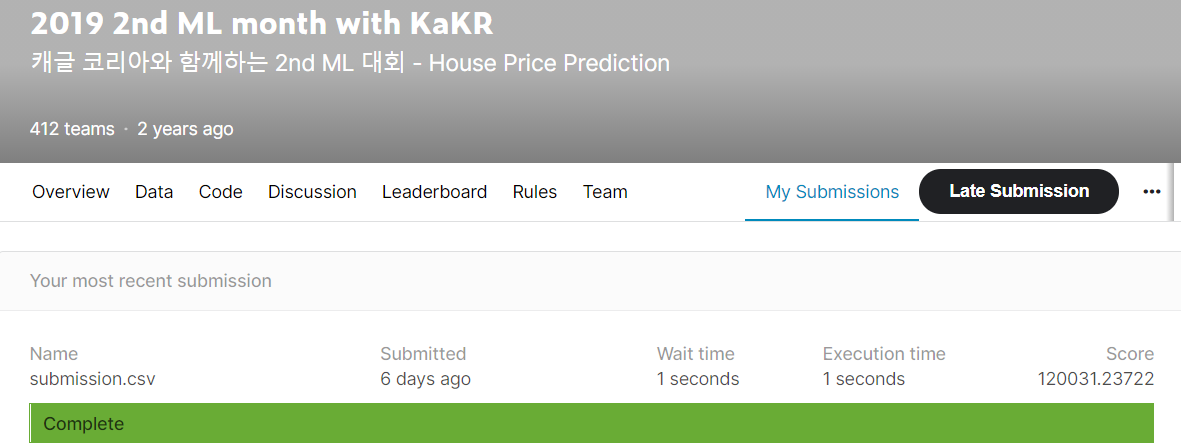

**score: 11만 아래로 내리는 것이 목표**

-----
-----
## <score 11만을 위한 결과개선>

### 1. 데이터 전처리

##### 1) 변수 date 전처리  
date도 문자가 아니라 int 자료형으로 변환해서  
예측값을 도출하기 위한 하나의 특성(척도)로 사용할 수 있음

In [51]:
#다시 데이터를 한번 가져와보자 
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [52]:
#date 변수 
#필요부분만 도출(연,월만 나오게)
#문자형에서 정수형 자료타입으로 바꾸기

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

#앞에서 전처리한 train 데이터를 x 에 넣어줌

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


##### 2) 데이터 전처리 수정이 반영된 소스코드 (price 말고 다른 컬럼도 정규화해야함)

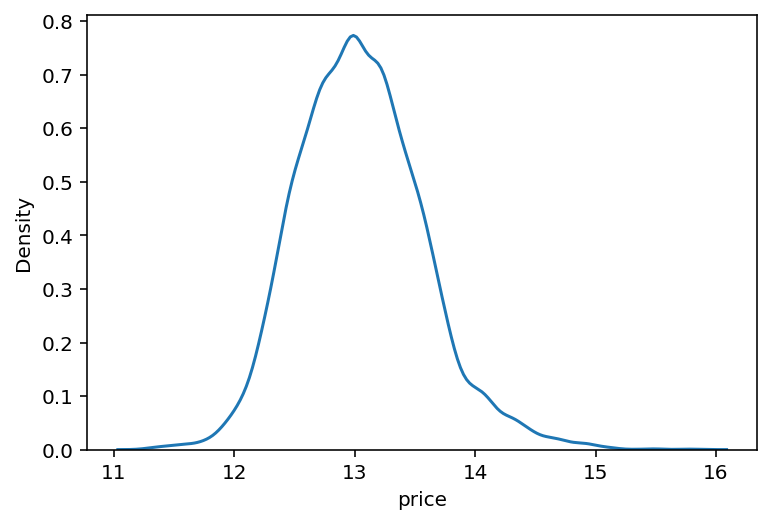

In [53]:
##1.데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

##2. 데이터 전처리
#필요없는 id 컬럼 삭제하자 
del train['id']
del test['id'] 

#date 컬럼 정수형+ 필요부분만 도출
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

#price컬럼 타겟데이터니까, y변수로 두고 train에서는 삭제
#학습할건데,,, 당근 train 데이터에는 있으면 안되지 ㅎㅎ
y = train['price']
del train['price']

#test에는 price 존재 하지 않음

#y= price 로그 변환 : np.log1p()
y = np.log1p(y)

#시각화
sns.kdeplot(y)
plt.show()

#모델 통해서, 집 값 예측한 뒤에 np.expm1()로 다시 로그함수 풀어줄 예정
#np.expm1() : 원소 x마다 exp(x)-1 값 반환 <- log함수 반대
#https://numpy.org/doc/stable/reference/generated/numpy.expm1.html

##### 3) date 비롯한 다른 컬럼들 자료형 확인

In [54]:
#전체 데이터의 자료형 확인해보자 
#info() : 전체 데이터의 자료형 확인
train.info()

#모두 실수 또는 정수 자료형 -> 모두 모델학습에 활용 가능한 특성들
#위에서는 에러 났지만 다시 첨부터 불러와서 하니까 잘 됨

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 2. RMSE 계산 함수 생성 (반복 작업 함수화하기)

##### 1) RMSE 계산에 필요한 함수들 import 해오기

In [55]:
# 필요한 라이브러리 임포트하기
from sklearn.model_selection import train_test_split

#mean_squared_error : MSE : 오차의 제곱에 대한 평균
from sklearn.metrics import mean_squared_error
#RMSE : 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근
# = MSE를 루트씌운 값(제곱근)

#모델 4개 import
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

##### 2) RMSE계산해주는 함수 생성
주의점 :  
y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값  
원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 함

In [56]:
def rmse(y_test, y_pred):
    #np.expm1() : 원래 데이터 단위 맞게 log 풀어줌
    #mean_squared_error로 오차 제곱의 평균 구함
    #np.sqrt(): 인자의 제곱근 (루트 씌운 값)
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

random_state  
모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값  

random_state=None #아무것도 지정 x  
random_state=숫자 #고정값으로 지정 o

고정값을 두면, 모델과 데이터셋이 동일한 경우  
-> 학습 결과도 항상 동일하게 재현됨  

현재 우리는 베이스라인부터 다양한 실험을 통해 성능 개선에 대한 검증을 하려고함  
이때 어떤 시도가 모델 성능향상에 도움이 됐는지 판단하기위해  
랜덤 요소 변화에 따른 불확실성을 제거해줘야함  

In [57]:
random_state=2021

#각각의 모델에 인스턴스 객체 생성
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

#각 모델에 생성된 객체를 model 리스트에 넣어두기
models = [gboost, xgboost, lightgbm, rdforest]

##### 3) 각 모델마다 RMSE 계산해서 출력해주는 함수 생성

In [58]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득 : 클래스의 각 객체에 대한 모델이름 __name__속성에 접근해서 알아보기 가능
        model_name = model.__class__.__name__
        
          # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
          # 모델 학습
        model.fit(X_train, y_train)
          # 예측
        y_pred = model.predict(X_test)
          # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
          #data frame에 각 모델과 rmse값 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [59]:
# 네 가지의 모델에 대해 RMSE값 구하기
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정한다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 137616.54606168193,
 'XGBRegressor': 126848.45135868828,
 'LGBMRegressor': 128291.75333011308,
 'RandomForestRegressor': 136497.21550154834}

##### 3) 각 모델마다 RMSE 계산해서 출력해주는 함수 생성

In [60]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득 : 클래스의 각 객체에 대한 모델이름 __name__속성에 접근해서 알아보기 가능
        model_name = model.__class__.__name__
        
          # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
          # 모델 학습
        model.fit(X_train, y_train)
          # 예측
        y_pred = model.predict(X_test)
          # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
          #data frame에 각 모델과 rmse값 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [61]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,137616.546062
RandomForestRegressor,136497.215502
LGBMRegressor,128291.753330
XGBRegressor,126848.451359


## 3.그리드 탐색_하이퍼파라미터 튜닝
모델과 데이터셋이 있다면,  
그것을 인자로 넣어 RMSE로 계산값을 도출해주는  
함수 get_scores를 만들었음  

이제 다양한 하이퍼 파라미터로 실험을 해봐야함  
(배치 사이즈, 임베딩 사이즈, 히든 사이즈, 에포크 등)  


##### 1) 그리드 서치 클래스 import

In [62]:
#sklearn.model_selection 라이브러리에서
#GridSearchCV 클래스 가져오기
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


##### 하이퍼파라미터 최적화를 위한 두가지 방법  
**1. 그리드 탐색**  
사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해둠  
그 값들로 만들어질 수 있는 모든 조합을 탐색  
특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리  
지정값들의 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있음  
<br>

**2. 랜덤 탐색**  
사람이 탐색할 하이퍼 파라미터의 공간만 정해두고,  
그 안에서 랜덤으로 조합을 선택해서 탐색  
최적의 조합을 찾을 수 있는 가능성이 언제나 열려있음  
하지만 그 가능성 또한 랜덤성에 의존하기 때문에 언제나 최적을 찾는다는 보장 없음  

우리는 그리드 탐색을 이용할건데  
그리드 탐색에 입력되는 인자들은 뭘까?

##### 그리드 탐색의 인자들
1. param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
2. scoring : 모델의 성능을 평가할 지표
3. cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
4. verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
5. n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수  
           -1로 지정해주면 모든 코어를 다 사용
6. refit : True가 디폴트로 True로 하면 최적의 하이퍼 파라미터를 찾아서 재학습 tlzla  
7. estimator : classifier, regressor, pipeline 등 가능

##### xgboost  
그레디언트 부스팅 알고리즘을 분산환경에서도  
실행할 수 있도록 구현해놓은 라이브러리  

여러개의 Decision Tree를 조합해서 사용하는 Ensemble 알고리즘

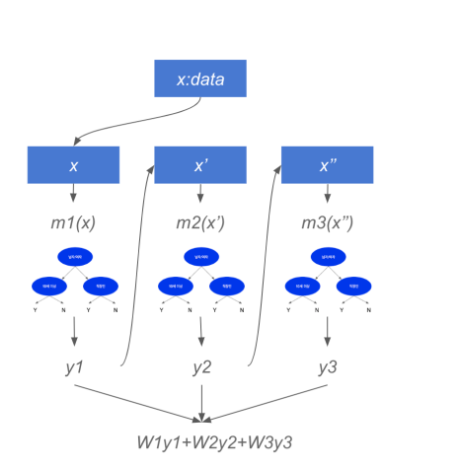
https://bcho.tistory.com/1354

##### 2) 그리드 파라미터  조합 설정

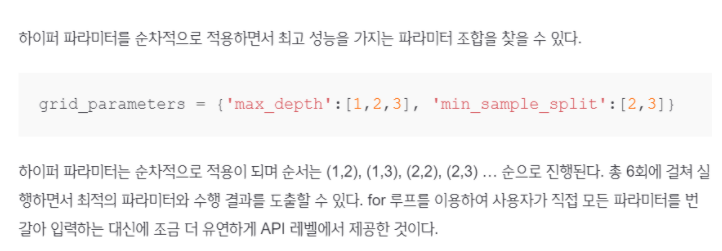

##### ① GridSearchCV 수행위한 필수인자1 : 탐색할 하이퍼 파라미터

In [63]:
#y1이 x2가 되고, y2가 x3가 됨 -> output이 다음 모델의 input이 됨

# xgboost 관련 탐색할 하이퍼파라미터를 넣음
#n_estimators : 생성할 tree의 개수

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

#총 4개의 조합
#(50, 1), (50, 10), (100, 1), (100, 10)

In [64]:
#위의 인덱스 이해가 안가서,, 확인 좀 시각적으로 해보려고 했는데,,
#csv 파일 뭘로 해야되나,, 데이터 넘많나
#import pandas as pd
#pd.read_csv('train.csv', index_col= '순번')

### random_state=random_state 뜻 몰까나,,

##### ② GridSearchCV 수행위한 필수인자2 : 학습할 모델 준비

In [65]:
#모델은 LightGBM(lgbm)를 사용

model = LGBMRegressor(random_state =random_state)

#model, param_grid 이 두개와 함께, 여러가지 인자를 함께 넣어서 GridSearchCV 수행 가능

### 아래  \가 뜻하는바는?

##### 3) 그리드 서치 학습  
하이퍼 파라미터 찾을 그리드 서치 모델을, 위에 지정한 LGBMRegressor 모델로 학습

In [66]:
#GridSearchCV로 grid_model 초기화


# scoring : 모델의 성능을 평가할 지표
#cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
#verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 
#n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
# 교차 검증을 위해 train 데이터셋을 5개로 나눠 검증 할 것임

#train, y 데이터로 모델 학습 
grid_model.fit(train, y)

#그러고 나면 param_gird 내의 모든 하이퍼 파라미터 조합에 대해 실험 완료

#여기서 totalling 20 fits 의미
#위에서  param_grid 통해 설정한 파라미터 조합은 4개
#여기서 교차 검증 위한 데이터는 5 구역
#각 구역마다 4번씩 시도 - > 20 fits

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    3.9s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2021), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

##### 4) 실험에 대한 결과 저장

In [67]:
grid_model.cv_results_

#정보가 너무 많이 나와,, 보기 힘들다
#우리가 알고 싶은 것 : 어떤 파라미터 조합일때 어떤 점수가 나올까?
#파라미터 조합은 : params 딕셔너리에
#각 테스트 점수는 : mean_test_score 딕셔너리에 저장되고 있음

{'mean_fit_time': array([0.20226202, 0.31320128, 0.54236012, 0.6788475 ]),
 'std_fit_time': array([0.03687318, 0.10189694, 0.13401272, 0.05040807]),
 'mean_score_time': array([0.01876163, 0.02160296, 0.03645582, 0.04140701]),
 'std_score_time': array([0.01404537, 0.00881238, 0.01245821, 0.01488203]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

##### 5) 실험 결과에 대한 확인

In [68]:
#파라미터 조합은 : params 딕셔너리에
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [69]:
#각 테스트 점수는 : mean_test_score 딕셔너리에 저장되고 있음
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [70]:
#데이터 프레임으로 결과 시각화
results = pd.DataFrame(params)
results['score'] = score

results

#근데 왜 점수가 다 음수로 나오지?
#우리가 GridSearchCV 초기화를 한 코드를 보면 알수 있다
# scoring 인자에 neg_mean_squared_error를 넣었다
#neg_mean_squared_error : MSE에 음수를 취한 값을 의미한다
#mean_squared_error : MSE : 오차의 제곱에 대한 평균

#다양한 점수체계(scoring) 사용할 수 있음
#3가지로 점수체계가 분류 됨 : Classification, Clustering, Regression
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

#우리는 Regression 문제를 다루고 있어서, 그에 알맞은 성능평가로 -MSE 선택한것

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


##### 6) RMSE/ RMLSE 로 스코어 변환 및 정렬

In [71]:
#RMSE 변환 함수
#음수를 양수로 바꾸고, MSE니까 루트 씌웟 RMSE 점수로 바꿈
results['RMSE'] = np.sqrt(-1 * results['score'])
results

#근데.. 앞에선 RMSE 값이 10만이였음
#왜 다르지?
#우리가 price 분포 정규화 한다고 log 변환 해줬었음
#아직 np.expm1()으로 변환하는 과정을 안거침
#즉 이건 RMSE가 아니라 RMSLE = Root Mean Squared Log Error 임

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [72]:
#그래서 컬럼이름 RMSE -> RMSLE로 변환
#판다스의 rename 사용
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [73]:
#RMSLE 낮은 값 부터 정렬
#price가 낮은 것 부터가 좋으니
#sort 면 오름차순

results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


##### 7) 그리드 탐색 및 결과 에 대한 함수 생성

In [74]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

## 4. 제출 함수 생성하기

##### 1) 그리드 서치(탐색)하기 : 위에 생성했던 함수로 

In [75]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

#가장 좋은 조합 = RMSLE가 낮은 조합 
#해당 모델로 예측값인 submission.csv 파일을 만들어서 제출해보자

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    2.0s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


##### 2) 예측값인 submission.csv 파일 생성

① 그리드 서치를 한 결과로 최적의 파라미터로 구성된 모델 준비
이후 예측 결과 생성

In [76]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

② log 계산해둔 price(RMLSE)를 다시 np.expm1()를 씌워 원래 스케일로 돌림

In [77]:
prediction = np.expm1(prediction)
prediction

#적당한 실수 값들로 예측함 -> 그래서 같은 가격
#id 와 price 두가지 열로 구성되어 있음 

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

③ 위에서 저장해뒀던 sample_submission.csv 파일 가져오기

In [78]:
import os 

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


④ 기존의 sample_submission.csv 파일에 예측된 price 값 덮어씌우기

In [79]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


⑤ 덮어씌워진 값으로 submission_csv 로 저장

In [80]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


##### 3) 위 과정을 모두 통합하여 제출 함수생성 

In [81]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    #모델로 train, y 학습
    model.fit(train, y)
    #test에 대한 y 예측값 도출
    prediction = model.predict(test)
    #예측값  np.expm1으로 변환
    prediction = np.expm1(prediction)
    
    #submission_csv 저장 과정
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [76]:
#위의 함수 이용해서 모델 학습 시키고 예측결과 업데이트해서 저장
#submission_model_name_RMSLE_100000.csv 이름으로 파일 저장
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


## 5. 개선결과

115688만 -> 5689만 줄이면 됨

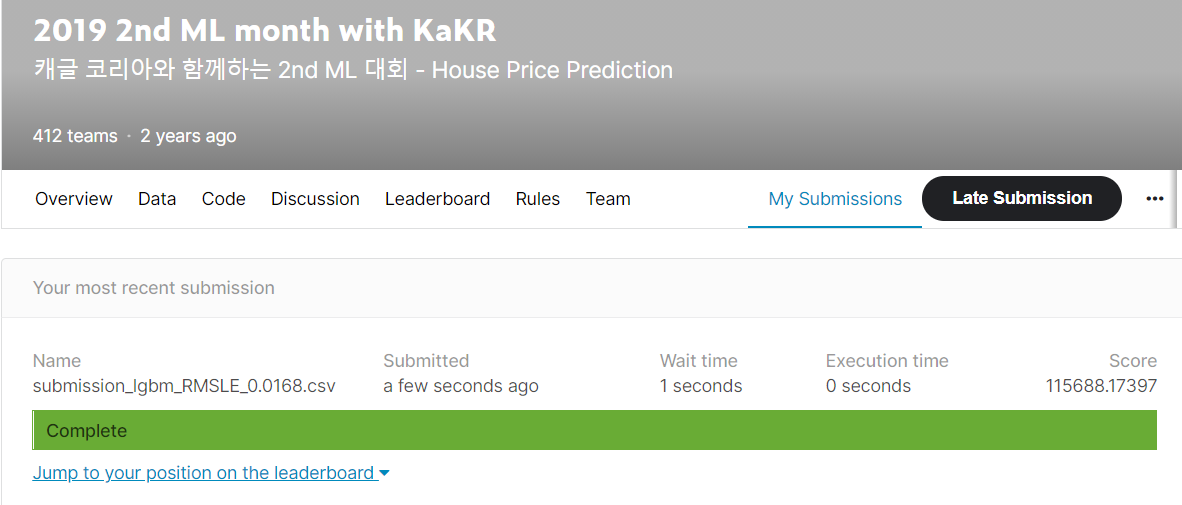

## 결과 개선 VER_2
위에서 만든 함수들로 편하게  ..!

##### Ligbm 모델_1

In [77]:
##1.데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

##2. 데이터 전처리
#필요없는 id 컬럼 삭제하자 
del train['id']
del test['id'] 

#date 컬럼 정수형+ 필요부분만 도출
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

#price컬럼 타겟데이터니까, y변수로 두고 train에서는 삭제
#학습할건데,,, 당근 train 데이터에는 있으면 안되지 ㅎㅎ
y = train['price']
del train['price']

#test에는 price 존재 하지 않음

#y= price 로그 변환 : np.log1p()
y = np.log1p(y)

#skew_columns =치우친 컬럼들 다 담은 리스트
#skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

#컬럼 하나씩 가져와서 데이터 분포 log로 정규화 해줌
#for c in skew_columns:
#    train[c] = np.log1p(train[c].values)

#### Lightgbm
:leaf-wise(best-first) Tree로 가로로 확장하며,  
가장 유망한 노드를 우선 탐색하는 알고리즘   

주요 하이퍼 파라미터  

<br>

* n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용  
<br>

* num_iteration [default=100] : 반복 수행하기 위한 트리의 개수 지정. 크게 지정할수록 예측 성능이 높아질 수 있지만 과적합 문제 가능성 또한 높아짐.  
<br>

* learning_rate [default=0.1] : 0~ 1 사이의 값을 지정해 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값.  
  일반적으로 n_estimators를 크게하고 learning_rate을 작게 해서 예측 성능 향상 가능, 과적합 이슈 동반.  
  한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~ 0.1 사이의 실수 사용
<br> 

* max_depth [default=-1]: 의사 결정 나무의 깊이, 정수 사용   
   0보다 작은 값을 지정하면 깊이에 제한 없음.
<br>  

* min_data_in_leaf [default=20] : 결정 트리의 min_samples_leaf와 동일. 최종 결정 클래스인 리프 노드가 되기 위해 최소한으로 필요한 레코드 수. (과적합 방지용)  
  - 아주 큰 데이터 셋(최소 10000건 이상)에서는 100~1000의 값이면 충분
  - default = 20
<br>

* num_leaves [default=32] : 하나의 트리가 가질 수 있는 최대 리프 수
  - 보통 num_leaves = 2^(max_depth)
  - depth-wise tree와 같은 수의 leaves를 가지게 하여,  
    이보다 작게 설정해야 오버피팅을 줄일 수 있음
  -  max_depth가 7일 경우 좋은 성능을 보였다면,  
     num_leaves는 127보다 적은 70~80사이에서 더 좋은 성능  
  - default = 0.31 
<br>

* boosting [default=gbdt] : 부스팅 트리를 생성하는 알고리즘 (gbdt:일반적인 그래디언트 부스팅, rf:랜덤포레스트)
<br>

* boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력  
<br>

* bagging_fraction [default=1.0] : 트리가 커져서 과적합 되는 것을 방지하기 위한 데이터 샘플링 비율.
<br>

* feature_fraction [default=1.0] : 개별 트리를 학습할 때 무작위로 선택되는 피처의 비율 (GBM의 max_features와 동일)
<br>

* lambda_I2 [default=0.0] : L2 regulation 제어를 위한 값. 피처 개수가 많을 경우 적용 검토. 값이 클수록 과적합 감소 효과
<br>

* lambda_I1[default=0.0] : L1 regulation 제어를 위한 값. 과적합 방지용.  

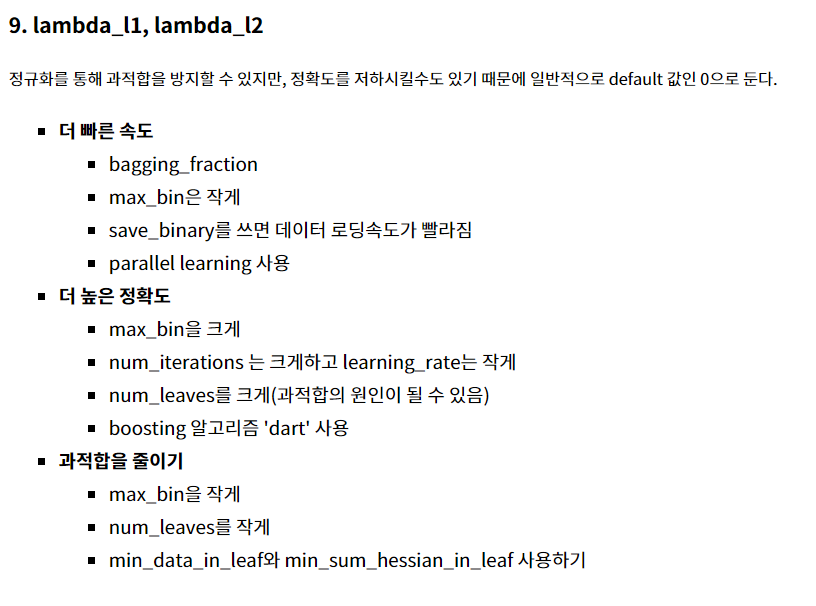

In [110]:
#그리드서치 하이퍼파라미터 조합
param_grid = {
    'learning_rate': [0.001, 0.05, 0.1],
    'n_estimators': [50, 75, 100],
    'max_depth': [1, 5, 10],
}
#모델준비
model = LGBMRegressor(random_state=random_state)
#그리드 탐색 및 결과 에 대한 함수 생성
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

#그리드 탐색을 통한 RMSLE값들 스케일 재변환(expm1),후 저장
save_submission(model, train, y, test, 'lgbm', rmsle='0.0169')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 135 out of 135 | elapsed:   17.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0169.csv saved!


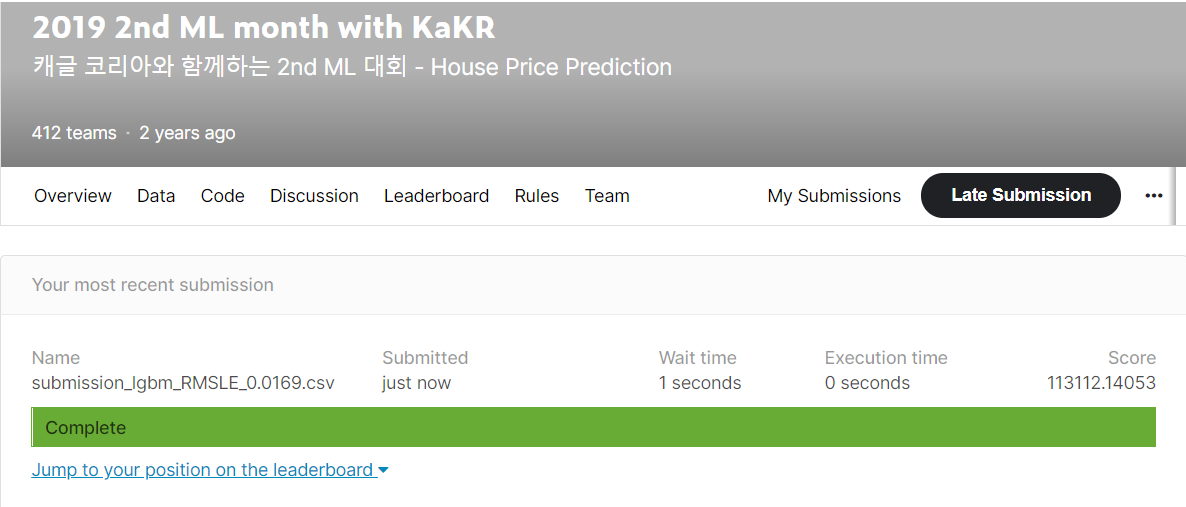

##### Ligbm 모델_2

In [114]:
##1.데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

##2. 데이터 전처리
#필요없는 id 컬럼 삭제하자 
del train['id']
del test['id'] 

#date 컬럼 정수형+ 필요부분만 도출
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

#price컬럼 타겟데이터니까, y변수로 두고 train에서는 삭제
#학습할건데,,, 당근 train 데이터에는 있으면 안되지 ㅎㅎ
y = train['price']
del train['price']

#test에는 price 존재 하지 않음

#y= price 로그 변환 : np.log1p()
y = np.log1p(y)

#skew_columns =치우친 컬럼들 다 담은 리스트
#skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

#컬럼 하나씩 가져와서 데이터 분포 log로 정규화 해줌
#for c in skew_columns:
#    train[c] = np.log1p(train[c].values)

In [ ]:
#그리드서치 하이퍼파라미터 조합
#    'num_leaves': [1, 25, 800],
#   'min_data_in_leaf': [100] 에 대해서 다시 학습,,
param_grid = {
    'learning_rate': [0.001, 0.05, 0.1],
    'n_estimators': [50, 75, 100],
    'max_depth': [1, 5, 10],
    'num_leaves': [1, 25, 800],
    'min_data_in_leaf': [100, 100, 100]
    
}
#모델준비
model = LGBMRegressor(random_state=random_state)
#그리드 탐색 및 결과 에 대한 함수 생성
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

#그리드 탐색을 통한 RMSLE값들 스케일 재변환(expm1),후 저장
save_submission(model, train, y, test, 'lgbm', rmsle='0.0171')

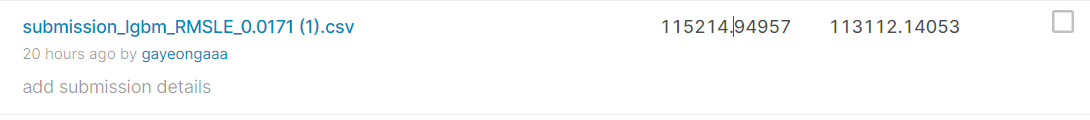

##### Ligbm 모델_3

In [119]:
##1.데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

##2. 데이터 전처리
#필요없는 id 컬럼 삭제하자 
del train['id']
del test['id'] 

#date 컬럼 정수형+ 필요부분만 도출
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

#price컬럼 타겟데이터니까, y변수로 두고 train에서는 삭제
#학습할건데,,, 당근 train 데이터에는 있으면 안되지 ㅎㅎ
y = train['price']
del train['price']

#test에는 price 존재 하지 않음

#y= price 로그 변환 : np.log1p()
y = np.log1p(y)

#skew_columns =치우친 컬럼들 다 담은 리스트
#skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

#컬럼 하나씩 가져와서 데이터 분포 log로 정규화 해줌
#for c in skew_columns:
#    train[c] = np.log1p(train[c].values)

In [120]:
#그리드서치 하이퍼파라미터 조합
#    'num_leaves': [1, 25, 800],
#   'min_data_in_leaf': [100] 에 대해서 다시 학습,,
param_grid = {
    'learning_rate': [0.001, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 5, 10],
    'num_leaves': [1, 25, 800],
    'min_data_in_leaf': [100]
    
}
#모델준비
model = LGBMRegressor(random_state=random_state)
#그리드 탐색 및 결과 에 대한 함수 생성
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

#그리드 탐색을 통한 RMSLE값들 스케일 재변환(expm1),후 저장
save_submission(model, train, y, test, 'lgbm', rmsle='0.0172')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 202 tasks      | elapsed:   17.2s
[Parallel(n_jobs=5)]: Done 405 out of 405 | elapsed:   38.7s finished


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0172.csv saved!


파라미터 개선 후에도 계속 해당 score만 나옴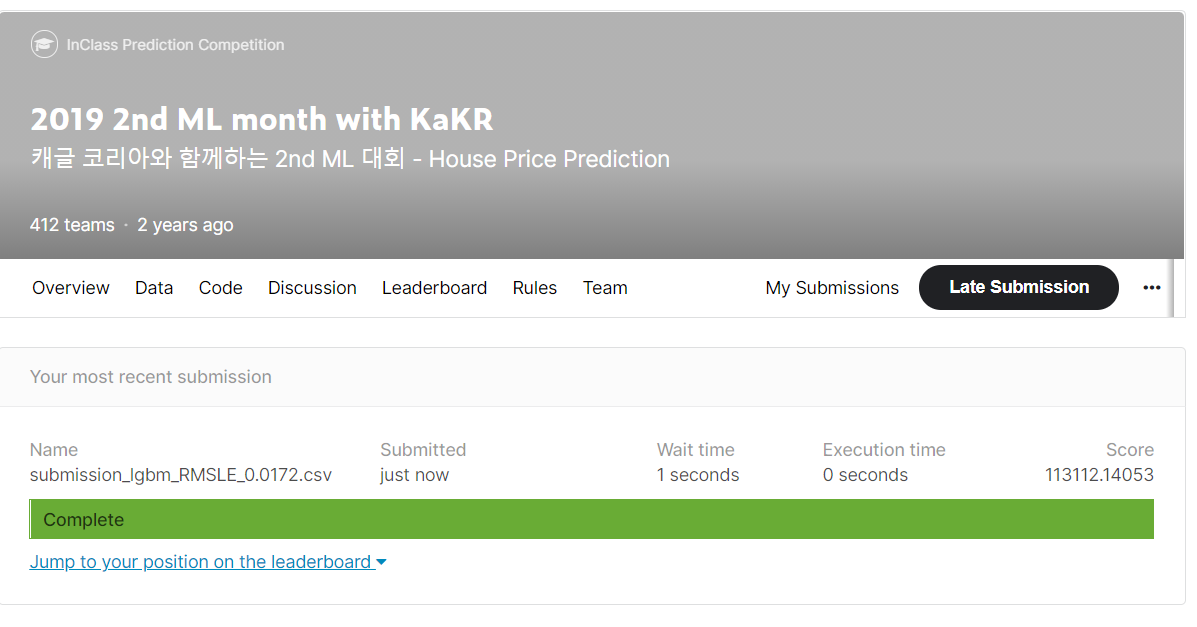

##### Ligbm 모델_4

In [84]:
##1.데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

##2. 데이터 전처리
#필요없는 id 컬럼 삭제하자 
del train['id']
del test['id'] 

#date 컬럼 정수형+ 필요부분만 도출
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

#price컬럼 타겟데이터니까, y변수로 두고 train에서는 삭제
#학습할건데,,, 당근 train 데이터에는 있으면 안되지 ㅎㅎ
y = train['price']
del train['price']

#test에는 price 존재 하지 않음

#y= price 로그 변환 : np.log1p()
y = np.log1p(y)

In [86]:
#그리드서치 하이퍼파라미터 조합
#    'num_leaves': [1, 25, 800],
#   'min_data_in_leaf': [100] 에 대해서 다시 학습,,
param_grid = {
    'learning_rate': [0.001, 0.05, 0.1],
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'num_leaves': [25, 800, 30000],
    'min_data_in_leaf': [100, 100, 100]
    
}
#모델준비
model = LGBMRegressor(random_state=random_state)
#그리드 탐색 및 결과 에 대한 함수 생성
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

#그리드 탐색을 통한 RMSLE값들 스케일 재변환(expm1),후 저장
save_submission(model, train, y, test, 'lgbm', rmsle='0.0180')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   24.9s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 1215 out of 1215 | elapsed:  6.3min finished


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0180.csv saved!


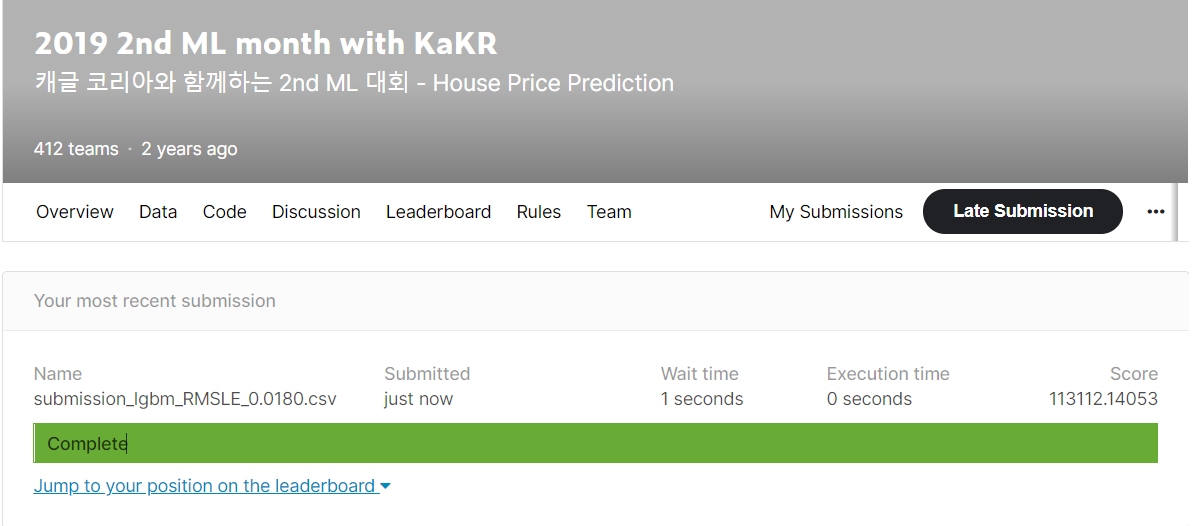

In [79]:
##1.데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

##2. 데이터 전처리
#필요없는 id 컬럼 삭제하자 
del train['id']
del test['id'] 

#date 컬럼 정수형+ 필요부분만 도출
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

#price컬럼 타겟데이터니까, y변수로 두고 train에서는 삭제
#학습할건데,,, 당근 train 데이터에는 있으면 안되지 ㅎㅎ
y = train['price']
del train['price']

#test에는 price 존재 하지 않음

#y= price 로그 변환 : np.log1p()
y = np.log1p(y)


In [42]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,137616.546062
RandomForestRegressor,136497.215502
LGBMRegressor,128291.753330
XGBRegressor,126848.451359


### 모델 바꿔보기
LGBMRegressor 보다 더 낮은 값이 보이는
XGBRegressor로 모델 변환

XGBRegressor 주 하이퍼 파라미터

- max_depth : 트리 당 최대 깊이. 더 깊은 트리는 성능을 향상시킬 수 있지만 복잡성과 과적 합 가능성도 증가시킵니다.
값은 0보다 큰 정수 여야합니다. 기본값은 6입니다.
- learning_rate : 학습률은 모델이 목표를 향해 최적화하는 동안 각 반복에서 단계 크기를 결정합니다. 학습률이 낮 으면 계산 속도가 느려지고 학습률이 높은 모델과 동일한 잔차 오류 감소를 달성하려면 더 많은 라운드가 필요합니다. 그러나 최상의 최적에 도달 할 수있는 기회를 최적화합니다.
값은 0과 1 사이 여야합니다. 기본값은 0.3입니다.
- n_estimators : 앙상블의 나무 수. 부스팅 라운드 수에 해당합니다.
값은 0보다 큰 정수 여야합니다. 기본값은 100입니다.
- NB : 표준 라이브러리에서는 num_boost_round 라고합니다 .
- colsample_bytree : 각 트리에 대해 무작위로 샘플링 할 열의 비율을 나타냅니다. 과적 합을 개선 할 수 있습니다.
값은 0과 1 사이 여야합니다. 기본값은 1입니다.
- subsample : 각 트리에 대해 샘플링 할 관측치의 비율을 나타냅니다. 낮은 값은 과적 합을 방지하지만 과소 적합으로 이어질 수 있습니다.
값은 0과 1 사이 여야합니다. 기본값은 1입니다.
- alpha (reg_alpha) : 가중치에 대한 L1 정규화 (올가미 회귀). 많은 기능으로 작업 할 때 속도 성능이 향상 될 수 있습니다. 정수가 될 수 있습니다. 기본값은 0입니다.
- lambda (reg_lambda) : 가중치에 대한 L2 정규화 (Ridge Regression). 과적 합을 줄이는 데 도움이 될 수 있습니다. 정수가 될 수 있습니다. 기본값은 1입니다.
- 감마 : 감마는 의사 정규화 매개 변수 (라그랑주 승수)이며 다른 매개 변수에 따라 다릅니다. 감마가 높을수록 정규화가 높아집니다. 정수가 될 수 있습니다. 기본값은 0입니다.

In [131]:
model = XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    colsample_bytree=0.8,
    min_child_weight=1,
    subsample=1,
    alpha=0,
    gamma=0,
    reg_lambda= 1,
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

#그리드 탐색 및 결과 에 대한 함수 생성
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

#그리드 탐색을 통한 RMSLE값들 스케일 재변환(expm1),후 저장
save_submission(model, train, y, test, 'XGB', rmsle='0.0175')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed: 49.3min
[Parallel(n_jobs=5)]: Done 405 out of 405 | elapsed: 73.8min finished


[18:42:32] WARNING: ../src/learner.cc:541: 
Parameters: { min_data_in_leaf, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


/aiffel/aiffel/kaggle_kakr_housing/data/submission_XGB_RMSLE_0.0175.csv saved!


하이퍼 파라미터를 조정해도 계속 같은 SCORE가 나옴  
하이퍼 파라미터 값을 조정해도 그 영향이 미미하기 때문이거나  
제대로 의미있게 값을 변환하지 못한 것 같음  

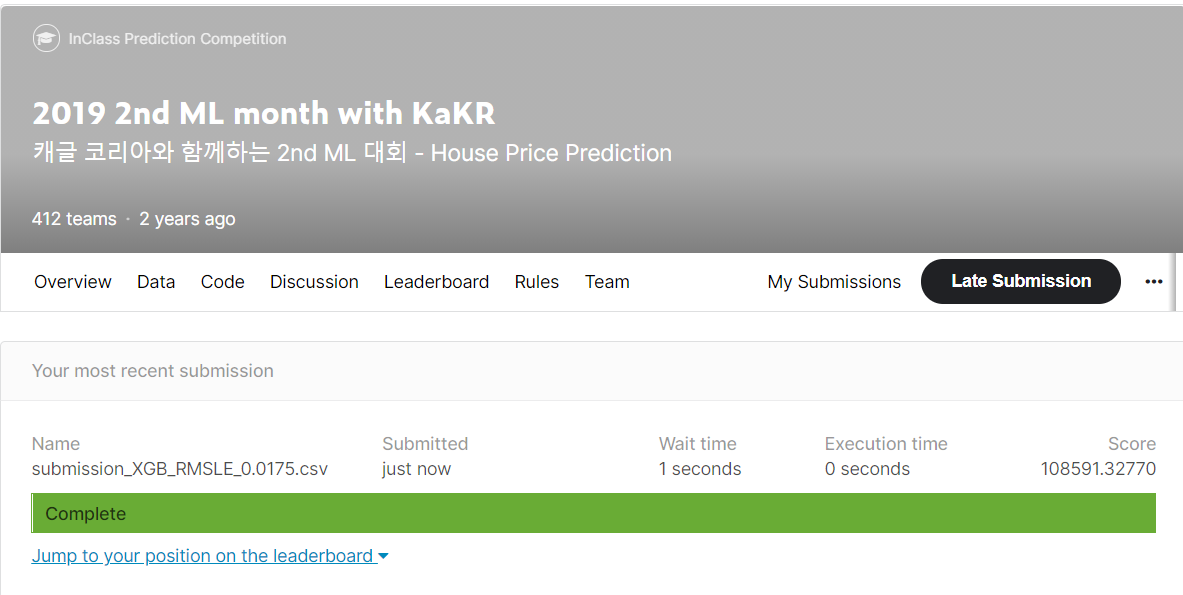

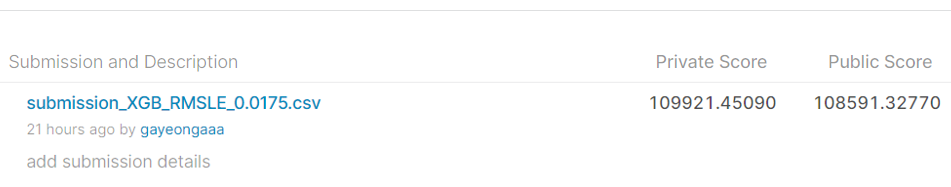

## 회고

##### 💚 루브릭  
1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?  
데이터 전처리가 논리적이었다  
id, price, date 컬럼의 데이터 전처리들과 함께  
log 변환으로 정규화를 해주고 다시 expm1으로 scale을 원래대로 되돌리며  
데이터 분석을 위한 데이터 전처리가 잘 이루어졌다고 판단된다  
이후 모델 학습, 제출 과정에 대한 함수를 만들었고  
이를 잘 사용해서 제출까지 성공적으로 완수했다 
<br>

2. 전처리, 학습과정 및 결과에 대한 설명이  
시각화를 포함하여 체계적으로 진행되었는가?  
해당 과정들에 대해서 넘버링과 주석을 세세하게 달아놓았다  
또한 데이터 분포도를 시각화하여 log 변환에 대한 필요성을 알 수 있었다.  
그리고 각 모델의 RMSLE 값이나 최종 예측값인 price에 대한 연산과정들을  
시각화하여 조금 더 빠르고 직관적인 판단을 할 수 있었다  
그리고 유의미한 시도들에 대해서  
기술하며 어떤 시도 들을 했는지에 대해서도 명확히 서술하고 있다  
<br>

3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?  
다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해  
캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.


##### 💚어려웠던 점   
**1. 앙상블 기법에 대한 이해가 어려웠다.**  
average, boost, blending 이 각각 하나의 앙상블 기법이라고 이해했는데,  
이게 어떻게 이렇게 혼합되어서 사용될 수가 있는건지 의아했다  
결국에는 저렇게 1),2),3) 내용으로 각 기법이 혼합되어 쓰여서  
앙상블이 되었다고 이해했다.  
해당 내용에 대해 오개념일 수도 있을 것 같아서 팀원들에게 물어보았지만  
역부족이었다.  
그래서 제출 후에 퍼실님들께 여쭤 보러 가야겠다 ㅎㅎ
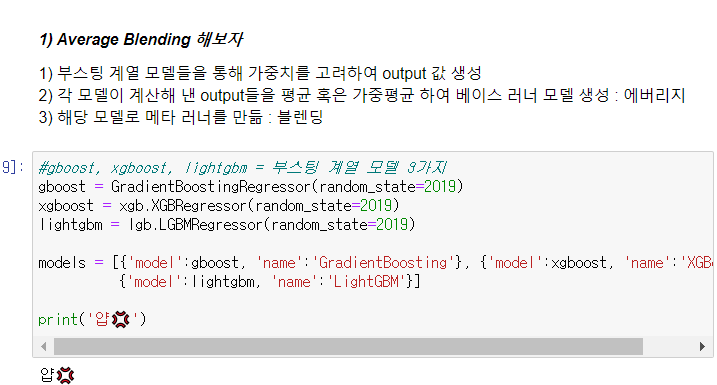  

**2. 하이퍼파라미터 조정에도 계속 같은 score**  
하이퍼 파라미터 값을 조정했는데도 불구하고  
캐글 score가 계속 같은 값이 나옴  
왜 그런지 이유를 잘 모르겠음  
추론해본 이유로는  
**'하이퍼 파라미터의 디폴트 값과 너무 차이가 있기 때문인가?'** 싶음  
디폴트 값이 가장 어느 데이터에서나 적절하고, 일반적으로 좋은 성능을 보이는 값인데  
이와 격차가 너무 벌어지면, 그만큼 기본적 성능과 멀어지는 것일 수도 있을듯  
내가 의도했던건 데이터 양과 max_depth를 반영해서  
하이퍼 파라미터 값을 조정해줘야한다고 생각했기 때문이었음  

##### 💚노력했던점
**1. 모델의 주 하이퍼 파라미터 공부**  
LGBMRegressor, XGBRegressor 모델의 하이퍼 파라미터 내용에 대해 공부했다.  
어떤 내용인지, 어떻게 쓰이는지 원리에 대해서  
**더 깊이 학습하여 이번 프로젝트에서 적용**하고자 했다.  
근데 내용과 원리를 이해해도 코드에 적용하는 것이 어렵고,  
이미 쓰여진 소스코드가 어떤 의미로 되어있는지 검색하는 것 조차 어려웠다  
하이퍼 파라미터를 학습하면서 논문도 접하게 되었는데  
해당 산업이 얼마나 빠르게 변화하는지  
그리고 그 변화를 받아들여서 얼마나 빠르게 학습하고 적용하려는 노력이 많은지에  
대해서 느낄 수 있었던것 같다  
그래서 나도 계속해서 **배우는 태도를 유지**하는 노력을 해야겠다고 다짐했다  

**2. 앙상블 기법 공부**  
앙상블의 각 기법에 대한 원리를 한번에 이해하기가 어려웠다  
그래서 많은 블로그 글들과 유뷰트 강의, 논문의 내용들을 보면서 학습하고  
정리하고자 했다   
실제로 많은 공부가 되었는데  
역시나,,, 지금 해당 프로젝트에서는 어떻게 구현되었는지 알아보기가  
좀 어려웠다,,,  

프로젝트를 마무리한 지금  
사실 나는 좋은 결과가 왜 나왔는지에 대해서,  
그냥 하이퍼 파라미터를 운좋게 좋은걸 찾았다고 밖에 말 못하겠다  
**1) 이 데이터에서는 어떤 모델이 적합했다**   
**2) 그 이유는 지금 우리가 분석하는 데이터가 이러한 데이터이기 때문이다**  
**3) 또한 이러한 이유로 하이퍼 파라미터가 적절했던 것 같다**  
**4) 이 모델은 좋은 성능을 비교적 보이지 못했는데,**  
   **이건 이 모델이 가진 어떤 특성 때문이라고 생각한다**  
**이런 흐름의 사고와 논리를 쌓을 수 있는 통찰의 능력**이 어서 쌓였으면 좋겠다  
지금은 어떻게 더 배우고 노력해봐야할지 또 고민해봐야겠다  

##### 💚이후 도전하고 싶은것  
1.   
train과 test 데이터로만 나눌것이 아니라,  
validation 데이터셋을 만들어 놓고  
train에 대한 교차검증을 한후에 val으로 한번 정확도와 loss를 확인해서  
어느정도의 학습도를 가지는지 스스로 판단해보고, 
마지막에 test로 캐글에 제출하는 과정들을 해보고 싶다  
<br>

2.  
앙상블, 각 모델의 하이퍼 파라미터 개념에 대한 깊은 이해를 하여  
직관이 아니라  
나름의 논리를 통해 의사결정을 하고 싶다
